In [2]:
import os

current_path = os.getcwd()
print(current_path)


/fast/AG_Metzger/daniela/python


In [3]:
import torch

In [4]:
torch.cuda.is_available()

True

In [5]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *

In [6]:
disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/FRGB_disease_MSFTUBBTX_disease_MSF/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB4_wt_msftubbtx_wild_type_MSF')
def get_label(o):
    if o.parent.name == 'FRGB_disease_MSFTUBBTX_disease_MSF':
        return 'disease'
    elif o.parent.name == 'fRGB4_wt_msftubbtx_wild_type_MSF':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")

In [8]:
disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.2, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=16, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')


val_indices = range_of(dls.valid)
val_files = [files[i] for i in val_indices]
val_preds = learn.get_preds(dl=dls.valid)





mean_preds = val_preds[0].mean()
std_preds = val_preds[0].std()



learn.export('model_tuned_msf_btx_tub.pkl')

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The accuracy of the model is 100.00%.


Results saved at: /fast/AG_Metzger/daniela/python/python_folder/resultsMSF.csv


/tmp/6637046.1.gpu.q/ipykernel_205632/2990275097.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, palette=['green', 'red'], alpha=0.5)


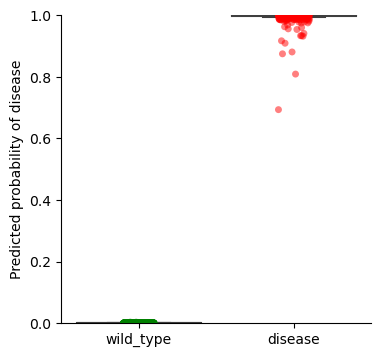

Image saved at: /fast/AG_Metzger/daniela/python/python_folder/msfbtxtubb3_probs


<Figure size 640x480 with 0 Axes>

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


val_preds, val_targs = learn.get_preds(dl=dls.valid)


df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})
df_valid.to_csv('/fast/AG_Metzger/daniela/python/python_folder/results_train_MSF', index=False)
print("Results saved at: /fast/AG_Metzger/daniela/python/python_folder/resultsMSF.csv")


fig, ax = plt.subplots(figsize=(4, 4))
sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, palette=['green', 'red'], alpha=0.5)
sns.boxplot(data=df_valid, x='class', y='prediction', ax=ax, boxprops={'facecolor': 'None'}, fliersize=0)
sns.despine()


ax.set_xlabel('')
ax.set_ylabel('Predicted probability of disease')
ax.set_ylim([0, 1])
plt.show()


image_path = '/fast/AG_Metzger/daniela/python/python_folder/msfbtxtubb3_probs'
plt.savefig(image_path, format='jpeg')


print("Image saved at:", image_path)


In [10]:
val_preds, val_targs = learn.get_preds(dl=dls.valid)

df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})

disease_preds = df_valid[df_valid['class'] == 'disease']['prediction']
wild_type_preds = df_valid[df_valid['class'] == 'wild_type']['prediction']
mean_disease, mean_wild_type = np.mean(disease_preds), np.mean(wild_type_preds)
std_disease, std_wild_type = np.std(disease_preds), np.std(wild_type_preds)

z_prime = 1 - 3*(std_disease + std_wild_type) / abs(mean_disease - mean_wild_type)

print(f'The Z prime score for the validation set is {z_prime:.2f}')


The Z prime score for the validation set is 0.94


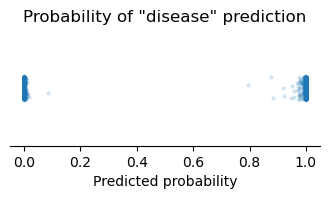

In [15]:
fig,ax = plt.subplots(figsize=(4,1.5))
sns.stripplot(data=df_valid, x='prediction', alpha=0.2, marker='.', s=6, ax=ax)
sns.despine(left=True)
ax.set_yticks([])
ax.set_xlabel('Predicted probability')
ax.set_title('Probability of "disease" prediction')
fig.savefig('compound_prob_high_snowflakes.pdf', bbox_inches='tight')

In [6]:
from fastai.learner import load_learner

model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_msf_btx_tub.pkl')


learn = load_learner(model_path)



In [11]:
import pandas as pd
from fastai.vision.all import *
import dill

test_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_msf_final_MSF_rescue/')
model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_msf_btx_tub.pkl')

learn_inf = load_learner(model_path, pickle_module=dill)

test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files)
preds, _ = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)
idx2label = {1: 'disease', 0: 'wild_type'}


results = []

for i, (pred_prob, pred_label_idx) in enumerate(zip(preds, pred_labels)):
    pred_label = idx2label[pred_label_idx.item()]
    probability = pred_prob[pred_label_idx].item()
    inverted_probability = 1 - probability  
    results.append({'File': test_files[i], 'Predicted Label': pred_label, 'Probability': probability, '1 - Probability': inverted_probability})


df = pd.DataFrame(results)


print(df)


                                                                                                                                                                                  File   
0     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_msf_final_MSF_rescue/r03c05_r03c05f02p35.tiff  \
1     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_msf_final_MSF_rescue/r04c06_r04c06f20p23.tiff   
2     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_msf_final_MSF_rescue/r03c05_r03c05f17p12.tiff   
3     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_msf_final_MSF_rescue/r03c08_r03c08f18p02.tiff   
4     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experimen

In [12]:
import pandas as pd

treatment_mapping = {
    'c01': 'Control',
    'c02': 'Control',
    'c03': '250 nM Risdiplam',
    'c04': '250 nM Risdiplam',
    'c05': '250 nM Risdiplam',
    'c06': '250 nM Risdiplam',
    'c07': '10 uM Prednisolone',
    'c08': '10 uM Prednisolone',
    'c09': '10 uM Prednisolone + 250 nM Risdiplam'
}


common_names = [f.name.split('_')[0] for f in test_files]
treatments = []
for cn in common_names:
    for code, treatment in treatment_mapping.items():
        if code in cn:
            treatments.append(treatment)
            break
    else:
        treatments.append('Unknown')


df1 = pd.DataFrame({'Common Name': common_names,'Probability': df['Probability'], '1 - Probability': df['1 - Probability'], 'Treatment': treatments})
rescue_scores = df1.groupby('Treatment')['Probability'].mean().reset_index()
std_deviations = df1.groupby('Treatment')['Probability'].std().reset_index()


for treatment, score, std_dev in zip(rescue_scores['Treatment'], rescue_scores['Probability'], std_deviations['Probability']):
    print(f'Treatment: {treatment}, Rescue Score: {score:.4f}, Standard Deviation: {std_dev:.4f}')


Treatment: 10 uM Prednisolone, Rescue Score: 0.9732, Standard Deviation: 0.0695
Treatment: 10 uM Prednisolone + 250 nM Risdiplam, Rescue Score: 0.9685, Standard Deviation: 0.0834
Treatment: 250 nM Risdiplam, Rescue Score: 0.9636, Standard Deviation: 0.0808


In [13]:
df1

Common Name  Probability  1 - Probability           Treatment
0         r03c05     0.996677         0.003323    250 nM Risdiplam
1         r04c06     0.984363         0.015637    250 nM Risdiplam
2         r03c05     0.999996         0.000004    250 nM Risdiplam
3         r03c08     0.963549         0.036451  10 uM Prednisolone
4         r04c06     0.745890         0.254110    250 nM Risdiplam
...          ...          ...              ...                 ...
8745      r04c05     0.954311         0.045689    250 nM Risdiplam
8746      r04c05     0.999829         0.000171    250 nM Risdiplam
8747      r03c06     0.983120         0.016880    250 nM Risdiplam
8748      r03c05     0.999858         0.000142    250 nM Risdiplam
8749      r03c06     0.999999         0.000001    250 nM Risdiplam

[8750 rows x 4 columns]

In [14]:
df1_copy = df1.copy()

In [15]:
df1_copy = df1[['Treatment', '1 - Probability']].copy()

In [16]:
df1_copy

Treatment  1 - Probability
0       250 nM Risdiplam         0.003323
1       250 nM Risdiplam         0.015637
2       250 nM Risdiplam         0.000004
3     10 uM Prednisolone         0.036451
4       250 nM Risdiplam         0.254110
...                  ...              ...
8745    250 nM Risdiplam         0.045689
8746    250 nM Risdiplam         0.000171
8747    250 nM Risdiplam         0.016880
8748    250 nM Risdiplam         0.000142
8749    250 nM Risdiplam         0.000001

[8750 rows x 2 columns]

In [17]:
df_valid

class    prediction
0     wild_type  5.003118e-06
1       disease  9.999721e-01
2     wild_type  3.627356e-04
3     wild_type  5.442199e-08
4       disease  9.947504e-01
...         ...           ...
1045    disease  9.995779e-01
1046    disease  9.975017e-01
1047  wild_type  2.412930e-08
1048    disease  9.987798e-01
1049    disease  9.934703e-01

[1050 rows x 2 columns]

In [18]:
df_valid = df_valid.rename(columns={'class': 'Treatment', 'prediction': '1 - Probability'})
df_valid

Treatment  1 - Probability
0     wild_type     5.003118e-06
1       disease     9.999721e-01
2     wild_type     3.627356e-04
3     wild_type     5.442199e-08
4       disease     9.947504e-01
...         ...              ...
1045    disease     9.995779e-01
1046    disease     9.975017e-01
1047  wild_type     2.412930e-08
1048    disease     9.987798e-01
1049    disease     9.934703e-01

[1050 rows x 2 columns]

In [19]:
combined_df = pd.concat([df1_copy, df_valid])
combined_df

Treatment  1 - Probability
0       250 nM Risdiplam     3.323078e-03
1       250 nM Risdiplam     1.563728e-02
2       250 nM Risdiplam     3.695488e-06
3     10 uM Prednisolone     3.645128e-02
4       250 nM Risdiplam     2.541103e-01
...                  ...              ...
1045             disease     9.995779e-01
1046             disease     9.975017e-01
1047           wild_type     2.412930e-08
1048             disease     9.987798e-01
1049             disease     9.934703e-01

[9800 rows x 2 columns]

In [20]:
unique_treatment_names = combined_df['Treatment'].unique().tolist()
print(unique_treatment_names)



['250 nM Risdiplam', '10 uM Prednisolone', '10 uM Prednisolone + 250 nM Risdiplam', 'wild_type', 'disease']


/tmp/6637046.1.gpu.q/ipykernel_205632/543756516.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_df, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


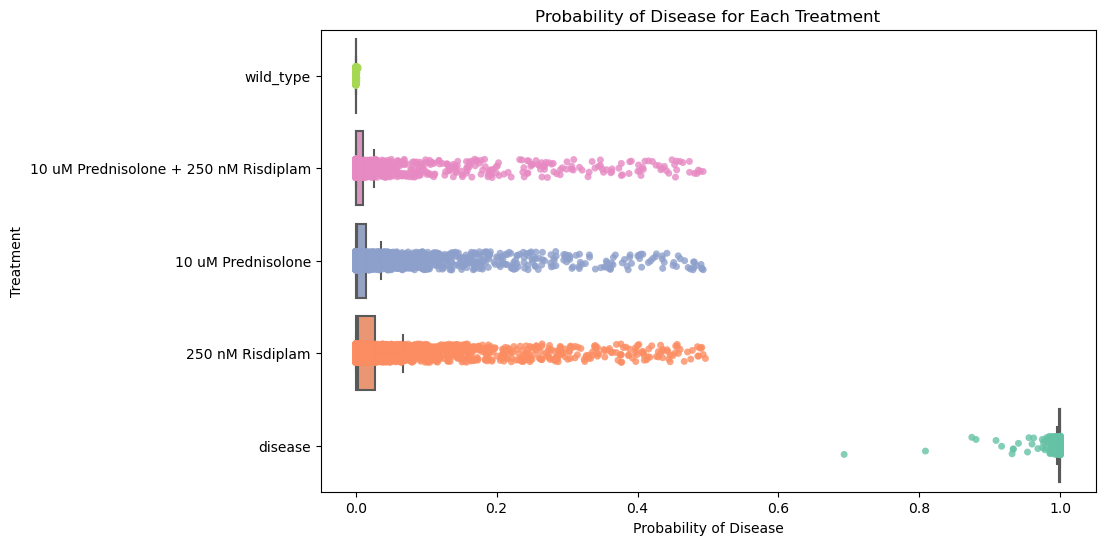

In [21]:
desired_order = ['disease', '250 nM Risdiplam', '10 uM Prednisolone', '10 uM Prednisolone + 250 nM Risdiplam', 'wild_type']
combined_df['Treatment'] = pd.Categorical(combined_df['Treatment'], categories=desired_order, ordered=True)


fig, ax = plt.subplots(figsize=(10, 6))
treatment_palette = sns.color_palette('Set2', n_colors=len(desired_order))
sns.boxplot(data=combined_df, x='1 - Probability', y='Treatment', ax=ax, showfliers=False, palette=treatment_palette)
sns.stripplot(data=combined_df, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)
ax.set_xlabel('Probability of Disease')
ax.set_ylabel('Treatment')
ax.set_title('Probability of Disease for Each Treatment')
ax.invert_yaxis()
plt.show()

In [ ]:
#Explainable AI: saliency Maps

In [1]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *
from captum.attr import Saliency
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
from PIL import Image

disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/FRGB_disease_MSFTUBBTX_disease_MSF/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB4_wt_msftubbtx_wild_type_MSF')
def get_label(o):
    if o.parent.name == 'FRGB_disease_MSFTUBBTX_disease_MSF':
        return 'disease'
    elif o.parent.name == 'fRGB4_wt_msftubbtx_wild_type_MSF':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")



disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.2, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=16, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')

val_indices = range_of(dls.valid)
val_files = [files[i] for i in val_indices]

val_preds = learn.get_preds(dl=dls.valid)


sample_idx = 0  
sample_image = PILImage.create(val_files[sample_idx]).convert('RGB')  


preprocess = learn.dls.after_item
sample = preprocess(sample_image)

input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No improvement since epoch 4: early stopping
The accuracy of the model is 100.00%.


In [2]:
sample_idx = 0 
sample_image = PILImage.create(val_files[sample_idx]).convert('RGB')  


preprocess = learn.dls.after_item
sample = preprocess(sample_image)


input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)


class_labels = ['disease', 'wild_type']  
target_index = class_labels.index('disease')  
saliency_map = saliency.attribute(input_tensor, target=target_index)
normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
gray_map = np.mean(normalized_map.squeeze().cpu().detach().numpy(), axis=0)

plt.imshow(gray_map, cmap='hot', vmin=0, vmax=1)
plt.axis('off')
plt.show()
sample_id = val_files[sample_idx].stem
print(sample_id)

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


r04c01_r04c01f20p29


In [ ]:
file_path = ('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB4_wt_msftubbtx_wild_type_MSF/r07c03f10p10.tiff')

original_image = PILImage.create(file_path).convert('RGB')
contrast_factor = 9.5  
enhancer = ImageEnhance.Contrast(original_image)
enhanced_image = enhancer.enhance(contrast_factor)



In [ ]:
preprocess = learn.dls.after_item
sample = preprocess(enhanced_image)


input_tensor = to_tensor(sample).unsqueeze(0)


input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)


target_index = class_labels.index('wild_type') 


saliency_map = saliency.attribute(input_tensor, target=target_index)


normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

red_channel_score = np.mean(normalized_map[:, 0].squeeze().cpu().detach().numpy())
green_channel_score = np.mean(normalized_map[:, 1].squeeze().cpu().detach().numpy())
blue_channel_score = np.mean(normalized_map[:, 2].squeeze().cpu().detach().numpy())

total_saliency_score = red_channel_score + green_channel_score + blue_channel_score



In [ ]:
red_channel_weight = red_channel_score / total_saliency_score
green_channel_weight = green_channel_score / total_saliency_score
blue_channel_weight = blue_channel_score / total_saliency_score
print(f"Red Channel Weight: {red_channel_weight:.4f}")
print(f"Green Channel Weight: {green_channel_weight:.4f}")
print(f"Blue Channel Weight: {blue_channel_weight:.4f}")


In [ ]:
gray_saliency_map = np.mean(normalized_map.squeeze().cpu().detach().numpy(), axis=0)
resized_saliency_map = ImageOps.fit(PILImage.create(gray_saliency_map), enhanced_image.size)
resized_saliency_map = np.array(resized_saliency_map)

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].imshow(enhanced_image)
axs[0].set_title('Original Image')
axs[0].axis('off')
im = axs[1].imshow(resized_saliency_map, cmap='cool', vmin=0, vmax=1)
axs[1].set_title('Saliency Map')
axs[1].axis('off')
cbar = plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label('Saliency Score')
axs[2].imshow(gray_saliency_map, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Grayscale Saliency Map')
axs[2].axis('off')
plt.show()

Red Channel Weight: 0.3131
Green Channel Weight: 0.4288
Blue Channel Weight: 0.2580


In [ ]:
original_image = PILImage.create(file_path).convert('RGB')
contrast_factor = 8.5  
enhancer = ImageEnhance.Contrast(original_image)
enhanced_image = enhancer.enhance(contrast_factor)
preprocess = learn.dls.after_item
sample = preprocess(enhanced_image)
input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)
saliency = Saliency(learn.model)


target_index = class_labels.index('wild_type')  


saliency_map = saliency.attribute(input_tensor, target=target_index)


normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())


threshold_mask = normalized_map >= 0.5


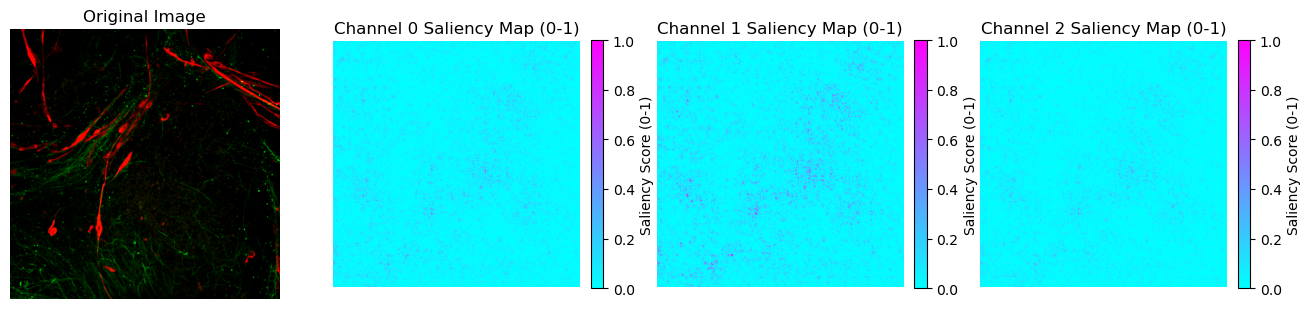

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5)) 
axs[0].imshow(enhanced_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

for channel in range(3):
    axs[channel + 1].imshow(normalized_map.squeeze()[channel].cpu().detach().numpy(), cmap='cool', vmin=0, vmax=1)
    axs[channel + 1].set_title(f'Channel {channel} Saliency Map (0-1)')
    axs[channel + 1].axis('off')


for ax in axs[1:]:
    cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Saliency Score (0-1)')

plt.show()

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


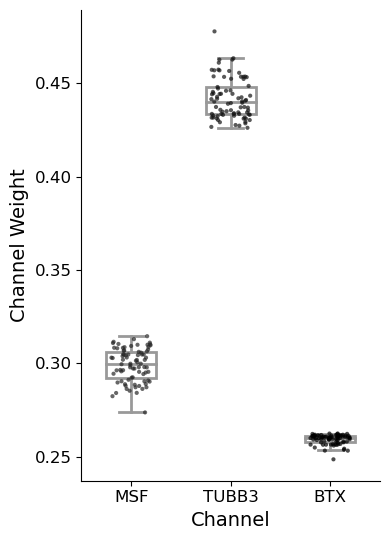

In [48]:
fig, ax = plt.subplots(figsize=(4, 5.5))
channels = ['MSF', 'TUBB3', 'BTX']
combined_weights = np.vstack((red_channel_weights, green_channel_weights, blue_channel_weights)).T
weights_df = pd.DataFrame(data=combined_weights, columns=channels)

sns.boxplot(data=weights_df, ax=ax, width=0.5, color='white', fliersize=0, linewidth=2)  # Increase box width and linewidth
sns.stripplot(data=weights_df, ax=ax, jitter=0.2, size=3, alpha=0.7, color='black')  # Smaller dots
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_ylabel('Channel Weight', fontsize=14)
ax.set_xlabel('Channel', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()